## Setup

In [1]:
import os


In [2]:
key = os.getenv("OPENAI_API_KEY")

In [3]:
# load the api key from txt file
with open('api_key.txt', 'r') as file:
   key = file.read().replace('\n', '')

In [4]:
# code to interact with the GPT 4 api with langchain to test the model on NLI using the TRE superglue dataset. I want to test on 5 categories of prompts each containing 5 promt templates: instructive, misleading- moderate, misleading- extreme, irrelevant, null. The model should be tested in a zero-shot, one-shot, and four-shot settings.

import openai
import json
import os
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# set the openai api key
if os.getenv("OPENAI_API_KEY"):
    key = os.getenv("OPENAI_API_KEY")


llm = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=key)

## Prompt templates

In [5]:
# define the prompt templates
prompt_templates = {
    "instructive": [
        "Given the premise '{premise}', does it logically lead to '{hypothesis}'?",
        "If '{premise}' is true, is '{hypothesis}' also true?",
        "If '{premise}' is true, does it imply '{hypothesis}'?",
        "Given that: '{premise}'. Can we say that '{hypothesis}'?",
        "If we know '{premise}', can we infer '{hypothesis}'?",
    ],
    "misleading_moderate": [
        "Answer trying to infer the task we want to perform. s1:'{premise}' s2:'{hypothesis}'",
        "Is the statement '{premise}' related to '{hypothesis}'?",
        "Is the statement '{premise}' in the same semantic category as '{hypothesis}'?",
        "Is the phrase '{premise}', somewhat linked to: '{hypothesis}'?",
        "Could we associate '{premise}' with '{hypothesis}'?",
    ],
    "misleading_extreme": [
        "Does the sentence '{premise}' contradict '{hypothesis}'?",
        "Do '{premise}' and '{hypothesis}' have the same amount of words?",
        "Is '{premise}' and '{hypothesis}' related to medicine?",
        "Could we use the sentences '{premise}' and'{hypothesis}' for a movie script?",
        "Are '{premise}' and'{hypothesis}' written by a monkey?",
    ],
    "irrelevant": [
        "This is an irrelevant question with '{premise}' as as string and '{hypothesis}' as another string",
        "Is there something better than '{premise}' and '{hypothesis}'?",
        "The flowers are blue. {premise} {hypothesis} Do we do the do?",
        "The Beatles one said: '{premise}' and '{hypothesis}' Should I jump?",
        "{premise} The cat is on the roof. {hypothesis} ?",
    ],
    "null": [
        "{premise} {hypothesis}",
        "{hypothesis} {premise} ",
        "{premise} -- {hypothesis}",
        "{hypothesis} -- {premise}",
        "{premise} and {hypothesis}",
    ]
}

## Structuring the output

In [6]:
from enum import Enum
from langchain_core.pydantic_v1 import BaseModel, Field


class ResponseOptions(Enum):
    YES = "Yes"
    NO = "No"

class Response(BaseModel):
    response_value: ResponseOptions = Field(description="The model's Yes or No response")

structured_lmm = llm.with_structured_output(Response)

In [7]:
from langchain_core.globals import set_debug
set_debug(True)

In [17]:
structured_lmm

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x11a736660>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x11a737a10>, openai_api_key=SecretStr('**********'), openai_proxy=''), kwargs={'tools': [{'type': 'function', 'function': {'name': 'Response', 'description': '', 'parameters': {'type': 'object', 'properties': {'response_value': {'description': "The model's Yes or No response", 'allOf': [{'title': 'ResponseOptions', 'description': 'An enumeration.', 'enum': ['Yes', 'No']}]}}, 'required': ['response_value']}}}], 'tool_choice': {'type': 'function', 'function': {'name': 'Response'}}})
| PydanticToolsParser(first_tool_only=True, tools=[<class '__main__.Response'>])

### Testing

In [53]:
# invoke the model
structured_lmm.invoke("Given the premise 'The cat is on the roof', does it logically lead to 'The cat is on the roof'?")


[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Given the premise 'The cat is on the roof', does it logically lead to 'The cat is on the roof'?"
}
[llm/start] [chain:RunnableSequence > llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the premise 'The cat is on the roof', does it logically lead to 'The cat is on the roof'?"
  ]
}
[llm/end] [chain:RunnableSequence > llm:ChatOpenAI] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "",
        "generation_info": {
          "finish_reason": "stop",
          "logprobs": null
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "",
            "additional_kwargs": {
              "tool_calls": [
              

Response(response_value=<ResponseOptions.YES: 'Yes'>)

## Setting-up few shots template

In [8]:
from langchain_core.prompts import (
    ChatPromptTemplate,
    FewShotChatMessagePromptTemplate,
)

### Testing

In [64]:
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "Given the premise '{premise}', does it logically lead to '{hypothesis}'?"),
        ("ai", "Yes"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=[],  
)

In [68]:
final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", ""),
        few_shot_prompt,
        ("human", "{prompt}")
    ]
)

In [69]:
final_prompt.invoke("daksjdkadn")

[chain/start] [prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "input": "daksjdkadn"
}
[chain/end] [prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]


ChatPromptValue(messages=[SystemMessage(content=''), HumanMessage(content='daksjdkadn')])

In [66]:
few_shot_prompt.invoke({"premise": "The cat is on the roof", "hypothesis": "The cat is on the roof"})

[chain/start] [prompt:FewShotChatMessagePromptTemplate] Entering Prompt run with input:
{
  "premise": "The cat is on the roof",
  "hypothesis": "The cat is on the roof"
}
[chain/end] [prompt:FewShotChatMessagePromptTemplate] s] Exiting Prompt run with output:
[outputs]


ChatPromptValue(messages=[])

### Generating the final prompt

In [9]:
def create_few_shot_prompt(prompt_template, samples=[]):
    
    example_prompt = ChatPromptTemplate.from_messages(
        [

            ("human", prompt_template),
            ("ai", "{label}"),
        ]
    )

    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=example_prompt,
        examples=samples,  
    )

    final_prompt = ChatPromptTemplate.from_messages(
        [
            few_shot_prompt,
            ("human", prompt_template)
        ]
    )

    return final_prompt
        

## Getting the data

In [10]:
import json

# load the TRE superglue dataset the test jsonl file is located in RTE folder
def load_data(file_path= "RTE/train.jsonl"):
    data = []
    with open(file_path, "r") as f:
        for line in f:
            data.append(json.loads(line))
    return data



In [12]:
# choose randomly 10 prompts from the dataset without replacement and with a seed

import random

seed = 123

random.seed(seed)


In [13]:
def convert_labels(data):
    for example in data:
        if example["label"] == "entailment":
            example["label"] = "Yes"
        else:
            example["label"] = "No"
    return data

In [14]:
# load the training data

train_data = load_data("RTE/train.jsonl")

train_data = convert_labels(train_data)

# randomly split the data in two sets
train_data_1 = random.sample(train_data, len(train_data)//2)
train_data_2 = [example for example in train_data if example not in train_data_1]

train_data = train_data_1 # used for the examples in the few-shot setting
test_data = train_data_2 # used to test the model

test_prompts = random.sample(test_data, 10)


# get four exaples 2 with entailment and 2 with non-entailment
def get_four_examples(data):
    entailment = [example for example in data if example["label"] == "Yes"]
    non_entailment = [example for example in data if example["label"] == "No"]
    return random.sample(entailment, 2) + random.sample(non_entailment, 2)

four_shot_examples = get_four_examples(train_data)

one_shot_example = four_shot_examples[:1]

two_shot_examples = [four_shot_examples[0] , four_shot_examples[2]]
# balanced examples

In [15]:
test_prompts

[{'premise': 'Dr Wood led a courageous and committed team in the fight to save 28 patients suffering from between two and 92 per cent body burns, deadly infections and delayed shock. As well as receiving much praise from both her own patients and the media, she also attracted controversy among other burns surgeons due to the fact that spray-on skin had not yet been subjected to clinical trials.',
  'hypothesis': "Burns surgeons approve Dr Wood's spray-on skin.",
  'label': 'No',
  'idx': 1475},
 {'premise': "NRDC states its mission as follows: The Natural Resources Defense Council's purpose is to safeguard the Earth: its people, its plants, animals, and the natural systems on which all life depends.",
  'hypothesis': 'The Natural Resources Defense Council safeguards the Earth.',
  'label': 'Yes',
  'idx': 1603},
 {'premise': 'The mine would operate nonstop seven days a week and use tons of cyanide each day to leach the gold from crushed ore.',
  'hypothesis': 'A weak cyanide solution i

In [16]:
two_shot_examples

[{'premise': "Jill Pilgrim, general counsel of USA Track and Field, brought up the issue during a panel on women's sports at the sports lawyers conference. Pilgrim said the law regarding who is legally considered a woman is changing as sex-change operations become more common.",
  'hypothesis': 'Sex-change operations become more common.',
  'label': 'Yes',
  'idx': 932},
 {'premise': "SCI, Houston's largest funeral services company, was headed by Robert Waltrip--a close associate of the Bush family.",
  'hypothesis': 'Robert Waltrip works for the Bush family.',
  'label': 'No',
  'idx': 1316}]

## Testing

In [16]:
one_prompt_template = prompt_templates["instructive"][0]

In [19]:
final_template  = create_few_shot_prompt(one_prompt_template, one_shot_example)

In [20]:
chain = final_template | structured_lmm


In [21]:
# get one test example 

test_example = test_prompts[0]

In [22]:
response = chain.invoke(test_example)

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "premise": "Garnett scored 15 points in the fourth quarter, with 13 of those points coming in the final 6:20 of the period. \"It's just about being a presence,\" Garnett said. \"It's about making them have to deal with me. I will continue to take that approach.\" In addition to his 44-point night, Garnett helped his team by not turning the ball over at all during the game. Such a performance was not the case for Steve Nash, who turned the ball over an uncharacteristic five times during the game. The Suns had 14 turnovers as a team. It was a case of Garnett and the Timberwolves taking full advantage of the mistakes the Suns made and turning it into an opportunity to win. However, the loss certainly didn't leave the Suns or their coach, Mike D'Antoni, discouraged. \"We'll start another [streak]. This is fun.\"",
  "hypothesis": "Garnett plays for the Timberwolves.",
  "idx": 2619
}
[chain/start] [chain:RunnableSequ

## Final experiment

### Testing

In [ ]:
# test running in parallel
from langchain_core.runnables import RunnableLambda, RunnableParallel

# construct chain for first template with one-shot example
one_shot_chain = create_few_shot_prompt(prompt_templates["instructive"][0], one_shot_example) | structured_lmm

# construct chain with two-shot example
two_shot_chain = create_few_shot_prompt(prompt_templates["instructive"][0], two_shot_examples) | structured_lmm

# construct chain with four-shot example
four_shot_chain = create_few_shot_prompt(prompt_templates["instructive"][0], four_shot_examples) | structured_lmm

# construct chain with 0 shot example
zero_shot_chain = create_few_shot_prompt(prompt_templates["instructive"][0], []) | structured_lmm

# Construct a RunnableParallel with a dictionary of runnables
parallel_runnable = RunnableParallel(
    {
        "one_shot": one_shot_chain,
        "two_shot": two_shot_chain,
        "four_shot": four_shot_chain,
        "zero_shot": zero_shot_chain,
    }
)

results = parallel_runnable.batch(test_prompts)
    


In [ ]:
results

### Running over all templates

###

In [17]:
from langchain_core.globals import set_debug
set_debug(False)

In [18]:
# running over all the prompt templates

#create the dictionary of chains that will be run in parallel
from langchain_core.runnables import RunnableLambda, RunnableParallel
import time



results = {}

for category, prompts in prompt_templates.items():
    chains_to_run = {}
    print(f"Generating for category: {category}")
    for i, prompt in enumerate(prompts):

        print(f"Generating for prompt: {prompt}")

        zero_shot_chain = create_few_shot_prompt(prompt, []) | structured_lmm
        one_shot_chain = create_few_shot_prompt(prompt, one_shot_example) | structured_lmm
        two_shot_chain = create_few_shot_prompt(prompt, two_shot_examples) | structured_lmm
        four_shot_chain = create_few_shot_prompt(prompt, four_shot_examples) | structured_lmm

        results[f"{category}_{i}"] = RunnableParallel(
            {
                "zero_shot": zero_shot_chain,
                "one_shot": one_shot_chain,
                "two_shot": two_shot_chain,
                "four_shot": four_shot_chain,
            }
        ).batch(test_prompts)

        # wait between each prompt to avoid rate limiting
        time.sleep(10)





Generating for category: instructive
Generating for prompt: Given the premise '{premise}', does it logically lead to '{hypothesis}'?
Generating for prompt: If '{premise}' is true, is '{hypothesis}' also true?
Generating for prompt: If '{premise}' is true, does it imply '{hypothesis}'?
Generating for prompt: Given that: '{premise}'. Can we say that '{hypothesis}'?
Generating for prompt: If we know '{premise}', can we infer '{hypothesis}'?
Generating for category: misleading_moderate
Generating for prompt: Answer trying to infer the task we want to perform. s1:'{premise}' s2:'{hypothesis}'
Generating for prompt: Is the statement '{premise}' related to '{hypothesis}'?
Generating for prompt: Is the statement '{premise}' in the same semantic category as '{hypothesis}'?
Generating for prompt: Is the phrase '{premise}', somewhat linked to: '{hypothesis}'?
Generating for prompt: Could we associate '{premise}' with '{hypothesis}'?
Generating for category: misleading_extreme
Generating for promp

## Saving the rusults

In [19]:
import pandas as pd

# dummy dict

dummy_dict = {
    "instructive_0": [
        {
            "one_shot": Response(response_value=ResponseOptions.YES),
            "two_shot": Response(response_value=ResponseOptions.YES),
            "four_shot": Response(response_value=ResponseOptions.YES),
            "zero_shot": Response(response_value=ResponseOptions.YES),
        },
        {
            "one_shot": Response(response_value=ResponseOptions.NO),
            "two_shot": Response(response_value=ResponseOptions.NO),
            "four_shot": Response(response_value=ResponseOptions.NO),
            "zero_shot": Response(response_value=ResponseOptions.NO),
        },

    ]
}

# reformat the data to a flat structure

def reformat_data(data):
    reformatted_data = []
    for key, value in data.items():
        for i, example in enumerate(value):
            reformatted_data.append(
                {
                    "category": key,
                    "prompt": i,
                    "one_shot": example["one_shot"].response_value,
                    "two_shot": example["two_shot"].response_value,
                    "four_shot": example["four_shot"].response_value,
                    "zero_shot": example["zero_shot"].response_value,
                }
            )
    # convert to data frame
    return pd.DataFrame(reformatted_data)


In [20]:
formatted_df = reformat_data(results)



In [21]:
formatted_df.head(12)

,category,prompt,one_shot,two_shot,four_shot,zero_shot
0,instructive_0,0,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
1,instructive_0,1,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES
2,instructive_0,2,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
3,instructive_0,3,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES
4,instructive_0,4,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
5,instructive_0,5,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
6,instructive_0,6,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
7,instructive_0,7,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
8,instructive_0,8,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES
9,instructive_0,9,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.NO


In [22]:
# save infor about test prompts and examples

# create dataframes for the test prompts and examples

test_prompts_df = pd.DataFrame(test_prompts)



In [23]:
test_prompts_df

,premise,hypothesis,label,idx
0,Dr Wood led a courageous and committed team in...,Burns surgeons approve Dr Wood's spray-on skin.,No,1475
1,NRDC states its mission as follows: The Natura...,The Natural Resources Defense Council safeguar...,Yes,1603
2,The mine would operate nonstop seven days a we...,A weak cyanide solution is poured over it to p...,No,2219
3,"On August 21, the Polish weekly Przekrój publi...",Readers of online encyclopedias can edit the c...,No,1758
4,U.S. crude settled $1.32 lower at $42.83 a bar...,Crude the light American lowered to the closin...,No,19
5,"Second-half goals, from Danny Mills and Darius...",Manchester was beaten by Everton.,No,935
6,Metropolitan police personnel specializing in ...,100 people were injured,No,1970
7,"The New Zealand Maori Queen, Te Arikinui Dame ...",Te Arikinui Dame Te Atairangikaah was a studen...,No,912
8,The Prime Minister of Spain Zapatero visited B...,Brazil is part of the United Nations.,Yes,2442
9,"Valero Energy Corp., on Monday, said it found ...",Valero Energy Corp. is the owner of Port Arthu...,Yes,931


In [24]:
four_shot_examples_df = pd.DataFrame(four_shot_examples)


In [25]:
four_shot_examples_df

,premise,hypothesis,label,idx
0,"Jill Pilgrim, general counsel of USA Track and...",Sex-change operations become more common.,Yes,932
1,Pope Benedict XVI is currently visiting Poland...,Benedict XVI is the Pope.,Yes,367
2,"SCI, Houston's largest funeral services compan...",Robert Waltrip works for the Bush family.,No,1316
3,Take consumer products giant Procter and Gambl...,500 small companies are partners of Procter an...,No,1423


In [26]:
# save the dataframes to csv files with the seed in the name

formatted_df.to_csv(f"results/responses_{seed}.csv", index=False)

test_prompts_df.to_csv(f"results/test_prompts_{seed}.csv", index=False)

four_shot_examples_df.to_csv(f"results/four_shot_examples_{seed}.csv", index=False)

# Visualizing the results

## Comparing over the labels

In [27]:
# load the data

import pandas as pd

seed = 11

responses = pd.read_csv(f"results/responses_{seed}.csv")

test_prompts = pd.read_csv(f"results/test_prompts_{seed}.csv")

four_shot_examples = pd.read_csv(f"results/four_shot_examples_{seed}.csv")

In [28]:
test_prompts

,premise,hypothesis,label,idx
0,Dr Wood led a courageous and committed team in...,Burns surgeons approve Dr Wood's spray-on skin.,No,1475
1,NRDC states its mission as follows: The Natura...,The Natural Resources Defense Council safeguar...,Yes,1603
2,The mine would operate nonstop seven days a we...,A weak cyanide solution is poured over it to p...,No,2219
3,"On August 21, the Polish weekly Przekrój publi...",Readers of online encyclopedias can edit the c...,No,1758
4,U.S. crude settled $1.32 lower at $42.83 a bar...,Crude the light American lowered to the closin...,No,19
5,"Second-half goals, from Danny Mills and Darius...",Manchester was beaten by Everton.,No,935
6,Metropolitan police personnel specializing in ...,100 people were injured,No,1970
7,"The New Zealand Maori Queen, Te Arikinui Dame ...",Te Arikinui Dame Te Atairangikaah was a studen...,No,912
8,The Prime Minister of Spain Zapatero visited B...,Brazil is part of the United Nations.,Yes,2442
9,"Valero Energy Corp., on Monday, said it found ...",Valero Energy Corp. is the owner of Port Arthu...,Yes,931


In [29]:
responses.head(12)

,category,prompt,one_shot,two_shot,four_shot,zero_shot
0,instructive_0,0,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
1,instructive_0,1,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES
2,instructive_0,2,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
3,instructive_0,3,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES
4,instructive_0,4,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
5,instructive_0,5,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
6,instructive_0,6,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
7,instructive_0,7,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
8,instructive_0,8,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES
9,instructive_0,9,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.NO


In [41]:
# get first category

categories = responses["category"].unique()

first_category = categories[0]

first_category_responses = responses[responses["category"] == first_category]


In [42]:
first_category_responses

,category,prompt,one_shot,two_shot,four_shot,zero_shot
0,instructive_0,0,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
1,instructive_0,1,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES
2,instructive_0,2,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
3,instructive_0,3,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES
4,instructive_0,4,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
5,instructive_0,5,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
6,instructive_0,6,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
7,instructive_0,7,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO
8,instructive_0,8,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES
9,instructive_0,9,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.NO


In [47]:
test_prompts['prompt'] = test_prompts.index

In [48]:
test_prompts

,premise,hypothesis,label,idx,prompt
0,Dr Wood led a courageous and committed team in...,Burns surgeons approve Dr Wood's spray-on skin.,No,1475,0
1,NRDC states its mission as follows: The Natura...,The Natural Resources Defense Council safeguar...,Yes,1603,1
2,The mine would operate nonstop seven days a we...,A weak cyanide solution is poured over it to p...,No,2219,2
3,"On August 21, the Polish weekly Przekrój publi...",Readers of online encyclopedias can edit the c...,No,1758,3
4,U.S. crude settled $1.32 lower at $42.83 a bar...,Crude the light American lowered to the closin...,No,19,4
5,"Second-half goals, from Danny Mills and Darius...",Manchester was beaten by Everton.,No,935,5
6,Metropolitan police personnel specializing in ...,100 people were injured,No,1970,6
7,"The New Zealand Maori Queen, Te Arikinui Dame ...",Te Arikinui Dame Te Atairangikaah was a studen...,No,912,7
8,The Prime Minister of Spain Zapatero visited B...,Brazil is part of the United Nations.,Yes,2442,8
9,"Valero Energy Corp., on Monday, said it found ...",Valero Energy Corp. is the owner of Port Arthu...,Yes,931,9


In [49]:
labels = test_prompts[['prompt', 'label']]

In [95]:
# merge the dataframes

responses_with_labels = responses.merge(labels, on="prompt")

In [96]:
responses_with_labels

,category,prompt,one_shot,two_shot,four_shot,zero_shot,label
0,instructive_0,0,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,No
1,instructive_0,1,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,Yes
2,instructive_0,2,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,No
3,instructive_0,3,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,No
4,instructive_0,4,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,No
...,...,...,...,...,...,...,...
245,null_4,5,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.YES,No
246,null_4,6,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.YES,No
247,null_4,7,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.NO,ResponseOptions.YES,No
248,null_4,8,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,ResponseOptions.YES,Yes


In [97]:

responses_with_labels[['one_shot', 'two_shot', 'four_shot', 'zero_shot']] = responses_with_labels[['one_shot', 'two_shot', 'four_shot', 'zero_shot']].map(lambda x: eval(x).value)

In [98]:
# compare the one-shot, two-shot, four-shot, and zero-shot columns with the label column with few operations


responses_with_labels["one_shot_correct"] = responses_with_labels["one_shot"] == responses_with_labels["label"]
responses_with_labels["two_shot_correct"] = responses_with_labels["two_shot"] == responses_with_labels["label"]

responses_with_labels["four_shot_correct"] = responses_with_labels["four_shot"] == responses_with_labels["label"]

responses_with_labels["zero_shot_correct"] = responses_with_labels["zero_shot"] == responses_with_labels["label"]




In [99]:
# convert the boolean values to integer

responses_with_labels[['one_shot_correct', 'two_shot_correct', 'four_shot_correct', 'zero_shot_correct']] = responses_with_labels[['one_shot_correct', 'two_shot_correct', 'four_shot_correct', 'zero_shot_correct']].astype(int)

In [158]:
# avarage the bollean values to get the accuracy grouped by category

accuracy = responses_with_labels.groupby("category")[["one_shot_correct", "two_shot_correct", "four_shot_correct", "zero_shot_correct"]].mean()

In [159]:
# rename the columns

accuracy.columns = ["one_shot_accuracy", "two_shot_accuracy", "four_shot_accuracy", "zero_shot_accuracy"]

In [160]:
accuracy['category'] = accuracy.index

In [161]:
accuracy.reset_index(drop=True, inplace=True)

In [162]:
accuracy["category_name"] = accuracy["category"].map(lambda x: x[:-2])

In [155]:
accuracy

,one_shot_accuracy,two_shot_accuracy,four_shot_accuracy,zero_shot_accuracy,category,category_name
0,0.9,0.9,0.9,0.8,instructive_0,instructive
1,0.9,0.9,0.8,0.8,instructive_1,instructive
2,0.9,0.9,0.8,0.9,instructive_2,instructive
3,0.8,0.9,0.9,0.8,instructive_3,instructive
4,0.9,0.9,0.9,0.9,instructive_4,instructive
5,0.8,1.0,1.0,0.8,irrelevant_0,irrelevant
6,0.4,0.7,0.6,0.3,irrelevant_1,irrelevant
7,0.6,0.9,1.0,0.6,irrelevant_2,irrelevant
8,0.7,0.7,1.0,0.6,irrelevant_3,irrelevant
9,0.9,0.9,0.8,0.9,irrelevant_4,irrelevant


## Plot the accuracies

In [118]:
accuracy

,one_shot_accuracy,two_shot_accuracy,four_shot_accuracy,zero_shot_accuracy,category,category_name
0,0.9,0.9,0.9,0.8,instructive_0,instructive
1,0.9,0.9,0.8,0.8,instructive_1,instructive
2,0.9,0.9,0.8,0.9,instructive_2,instructive
3,0.8,0.9,0.9,0.8,instructive_3,instructive
4,0.9,0.9,0.9,0.9,instructive_4,instructive
5,0.8,1.0,1.0,0.8,irrelevant_0,irrelevant
6,0.4,0.7,0.6,0.3,irrelevant_1,irrelevant
7,0.6,0.9,1.0,0.6,irrelevant_2,irrelevant
8,0.7,0.7,1.0,0.6,irrelevant_3,irrelevant
9,0.9,0.9,0.8,0.9,irrelevant_4,irrelevant


In [163]:
# rename one_shot_accuracy to one_shot, two_shot_accuracy to two_shot, four_shot_accuracy to four_shot, zero_shot_accuracy to zero_shot

accuracy.rename(columns={"one_shot_accuracy": "one-shot", "two_shot_accuracy": "two-shot", "four_shot_accuracy": "four-shot", "zero_shot_accuracy": "zero-shot"}, inplace=True)


In [164]:
accuracy

,one-shot,two-shot,four-shot,zero-shot,category,category_name
0,0.9,0.9,0.9,0.8,instructive_0,instructive
1,0.9,0.9,0.8,0.8,instructive_1,instructive
2,0.9,0.9,0.8,0.9,instructive_2,instructive
3,0.8,0.9,0.9,0.8,instructive_3,instructive
4,0.9,0.9,0.9,0.9,instructive_4,instructive
5,0.8,1.0,1.0,0.8,irrelevant_0,irrelevant
6,0.4,0.7,0.6,0.3,irrelevant_1,irrelevant
7,0.6,0.9,1.0,0.6,irrelevant_2,irrelevant
8,0.7,0.7,1.0,0.6,irrelevant_3,irrelevant
9,0.9,0.9,0.8,0.9,irrelevant_4,irrelevant


In [166]:
df_long = pd.melt(accuracy.drop(['category'], axis=1), id_vars=['category'], var_name='model', value_name='accuracy')


In [167]:
df_long

,category_name,model,accuracy
0,instructive,one-shot,0.9
1,instructive,one-shot,0.9
2,instructive,one-shot,0.9
3,instructive,one-shot,0.8
4,instructive,one-shot,0.9
...,...,...,...
95,null,zero-shot,0.5
96,null,zero-shot,0.4
97,null,zero-shot,0.8
98,null,zero-shot,0.5


In [168]:
df_long.columns = ['Category', 'Model', 'Accuracy']

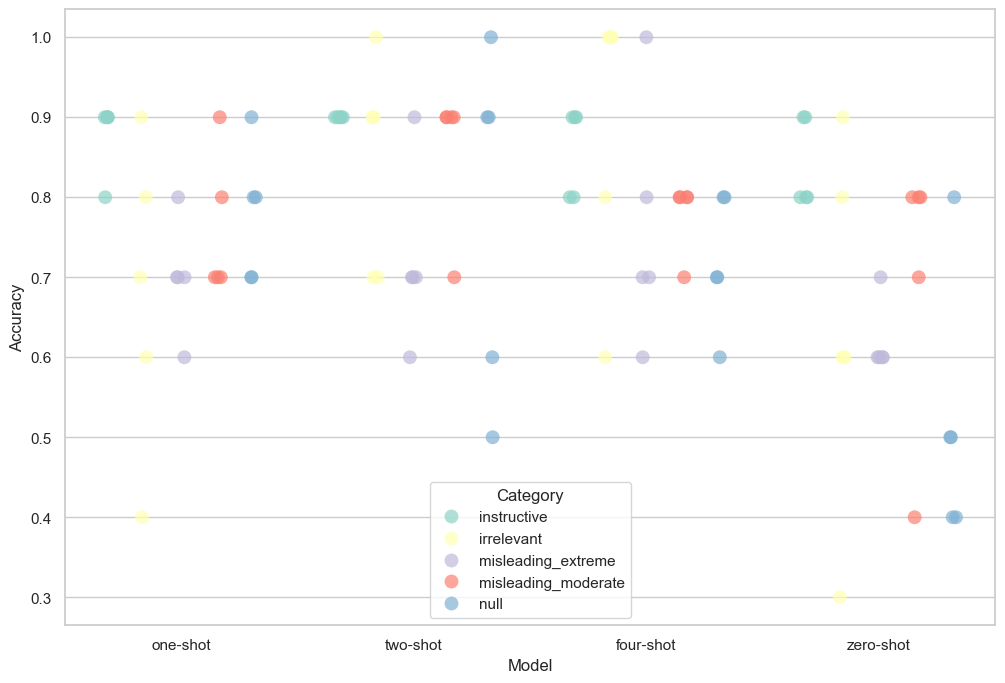

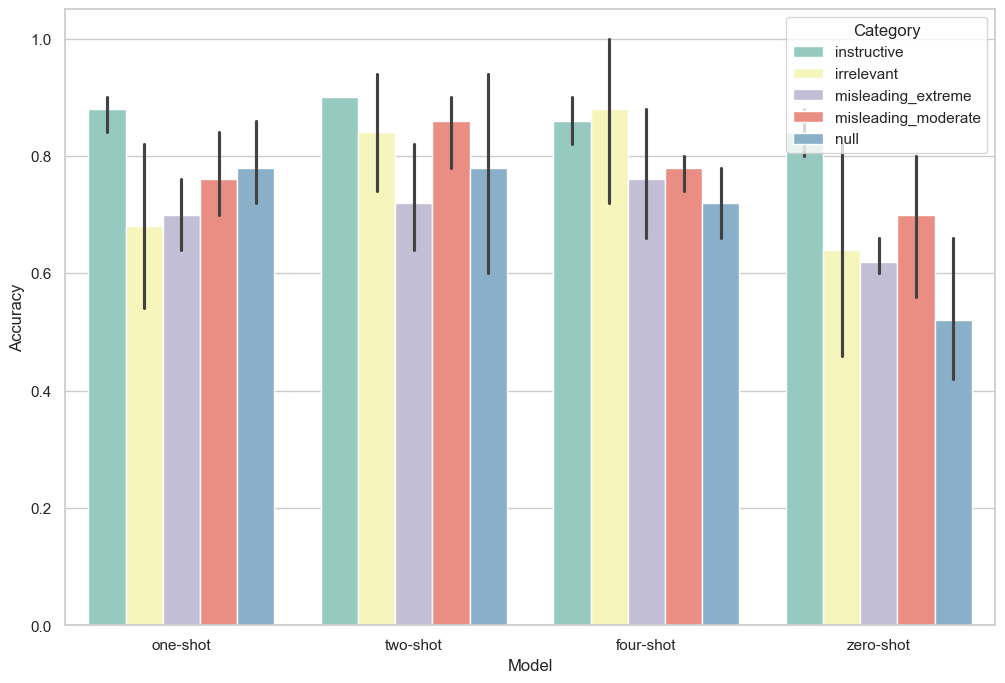

In [173]:
# plot the accuracies gruping by number of shots, and within each number of shots by category, blot them with dots
# the different shots will be represented by differen x labels while the categories will be represented by different colors

import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))



sns.stripplot(x="Model", y="Accuracy", hue="Category", data=df_long, 
              jitter=0.1, dodge=True, palette="Set3", size=10, alpha=0.7)

#plt.title("Accuracy by category and number of shots")




# save the plot

plt.savefig(f"figures/striplot_{seed}.png")

# do the same above but with scattered points

plt.figure(figsize=(12, 8))

sns.set_theme(style="whitegrid")

sns.barplot(x="Model", y="Accuracy", hue="Category", data=df_long, palette="Set3")

#plt.title("Accuracy by category and number of shots")


# save the plot

plt.savefig(f"figures/barplot_{seed}.png")

